In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import numpy as np
from dataset import *

from torch.utils.tensorboard import SummaryWriter

In [2]:
root_dir = "/home/gc28692/Projects/data/nvgesture/nvGesture_v1"

In [7]:
len(dataset)

838

In [3]:
tsfms = transforms.Compose([
    transforms.ToTensor()
    ]
)
dataset = Gestures(root_dir,tsfms,train=True,subset=[0,1,2,3,4,5,6,7,9,10,11,12,13,15,17,18,21,22,23,24])
train_set, val_set = torch.utils.data.random_split(dataset, [780, 58])
train_loader = DataLoader(train_set,batch_size=32)
val_loader = DataLoader(val_set,batch_size=32)
loss_fn = torch.nn.CrossEntropyLoss()

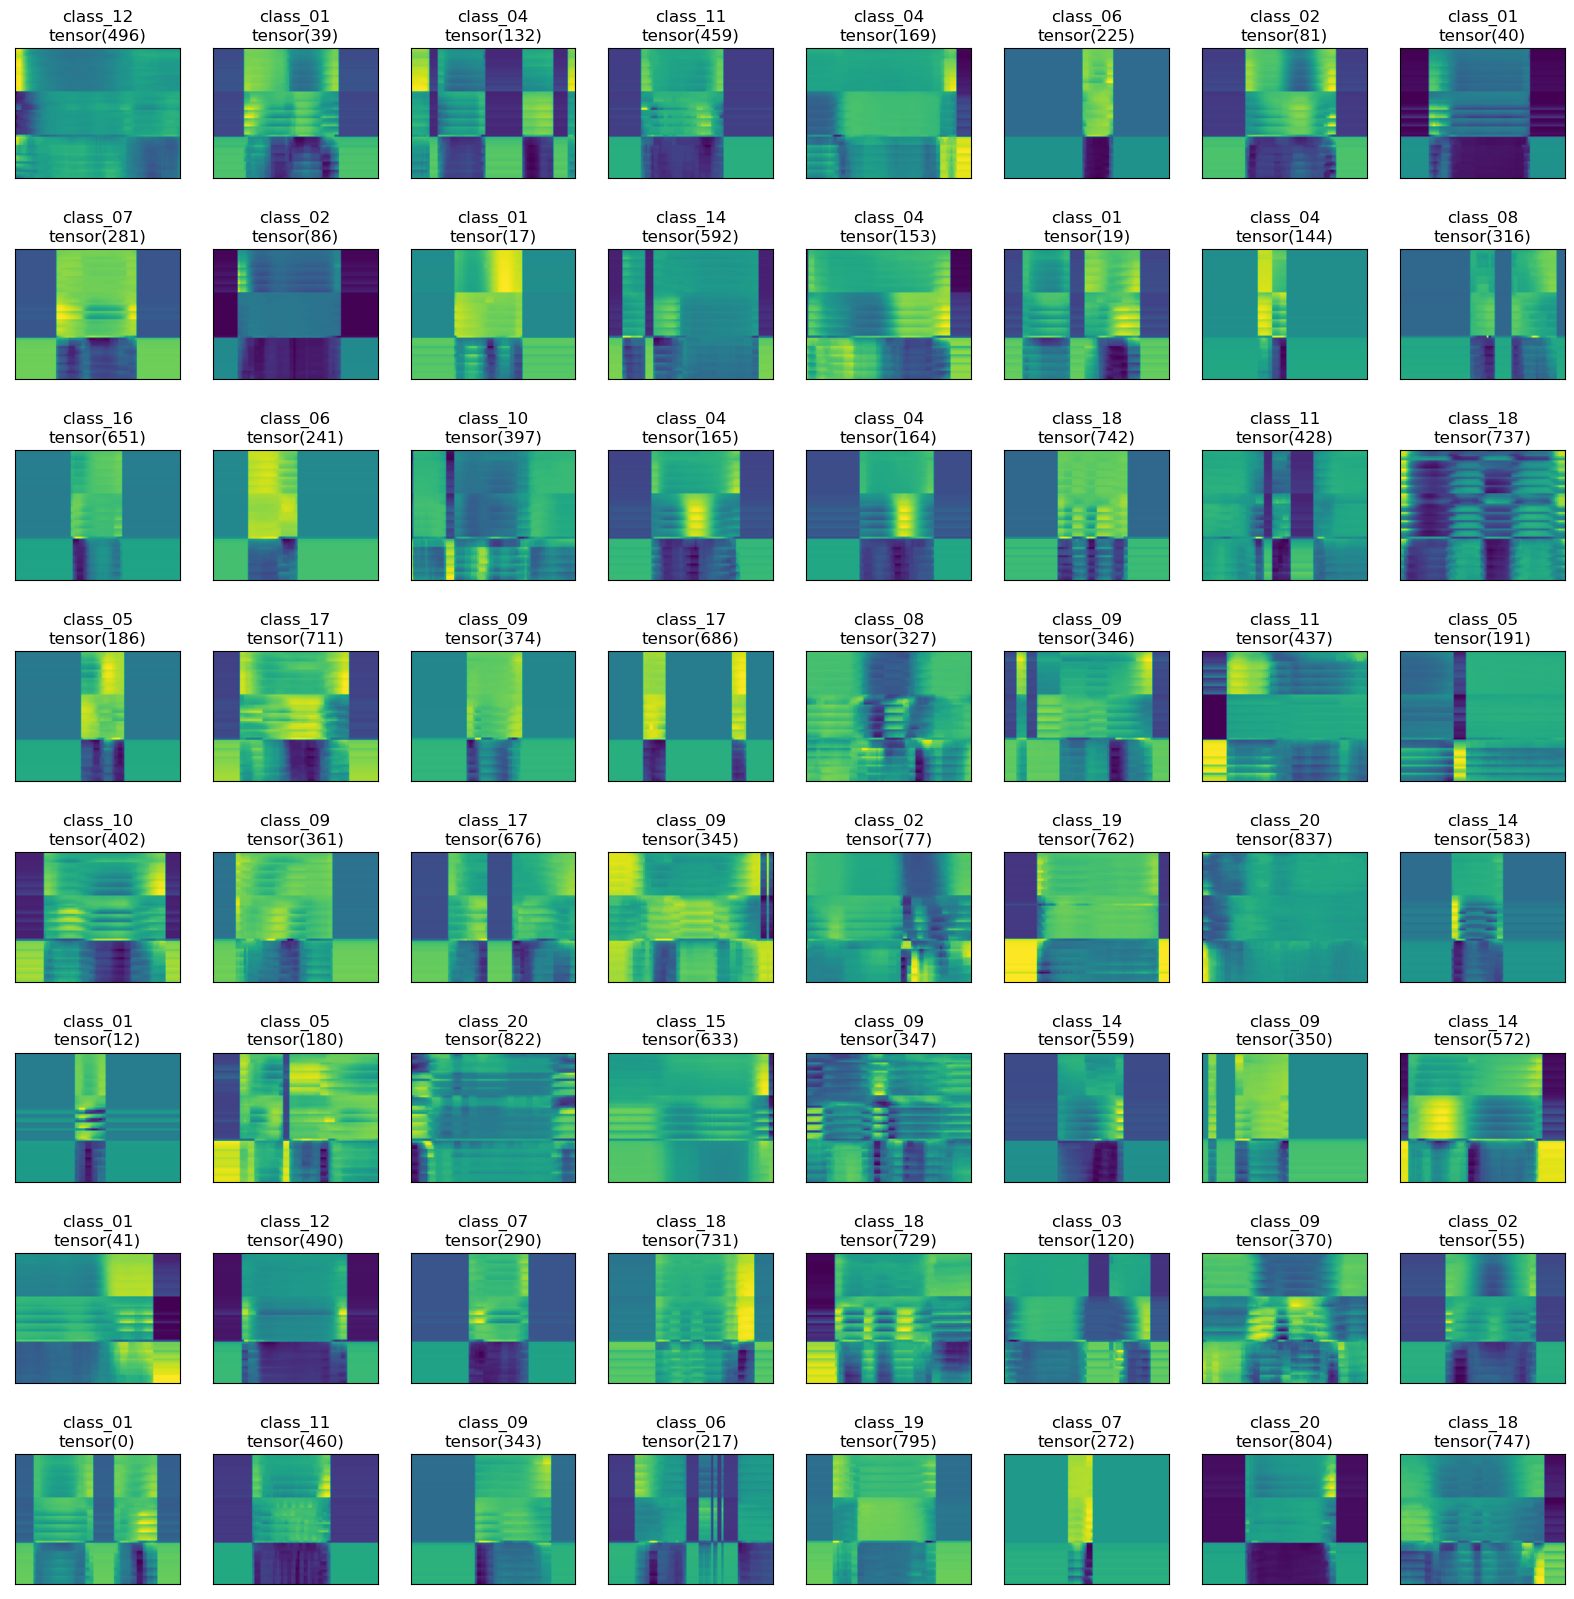

In [4]:
dataset.visualize_batch()

In [ ]:
# # Create RNN Model
# class RNNModel(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
#         super(RNNModel, self).__init__()
        
#         # Number of hidden dimensions
#         self.hidden_dim = hidden_dim
        
#         # Number of hidden layers
#         self.layer_dim = layer_dim
        
#         # RNN
#         # self.rnn = torch.nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
#         self.rnn = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
#         # Readout layer
#         self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(hidden_dim, 32) for i in range(80)])

#         self.final = torch.nn.Linear(32*80,output_dim)
#         self.do = torch.nn.Dropout()
    
#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to('cuda')
#         c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to('cuda')
            
#         # loop
#         out, (hi,ci) = self.rnn(x[:,0,:].unsqueeze(1), (h0,c0))
#         pred = self.do(self.fc_layers[0](out[:,-1,:]))
#         for i in range(1,x.shape[1]):
#             out, (hi,ci) = self.rnn(x[:,i,:].unsqueeze(1), (hi,ci))
#             pred = torch.cat([pred,self.do(self.fc_layers[i](out[:,-1,:]))],dim=1)

#         # print(pred.shape)
#         return self.final(pred)

In [5]:
# Create RNN Model
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        # self.rnn = torch.nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        # Readout layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to('cuda')
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to('cuda')
            
        # loop
        out, (hi,ci) = self.rnn(x[:,0,:].unsqueeze(1), (h0,c0))
        pred = self.fc(out[:,-1,:])
        for i in range(1,x.shape[1]):
            out, (hi,ci) = self.rnn(x[:,i,:].unsqueeze(1), (hi,ci))
            pred += self.fc(out[:,-1,:])
        return pred/x.shape[1]

In [6]:
model = RNNModel(63,256,1,25)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [9]:
import time
writer = SummaryWriter("runs/subset")
# create model, optimizer, and loss
gest_net = model.to('cuda')

losses = []
# epoch loop
b_i = 0
best_val = 0
for e in range(100):
    print(f"========== Training Epoch {e} ==========")
    i = 0
    # batch loop
    for img,target,_ in train_loader:
        img,target = img.to('cuda'),target.to('cuda')
        optimizer.zero_grad()

        # forward pass
        out = gest_net(img)
        # print(torch.argmax(out,dim=1))
        loss = loss_fn(out,target)
        writer.add_scalar("Metric/train",loss,b_i)
        # print(loss.item())
        if i % 10 == 0:
            print(f'Epoch {e}, batch ({i}/{len(train_loader)}), train loss: {loss}')
        losses.append(loss)

        # backward pass
        loss.backward()
        optimizer.step()
        i += 1
        b_i += 1
    # validation at the end of training
    i = 0
    val_loss = 0
    num_correct = 0
    total = 0
    print(f"========== Validation ==========")
    for idx, (img,target,_) in enumerate(val_loader):
        img,target = img.to('cuda'),target.to('cuda')
        with torch.no_grad():
            out = gest_net(img)
            val_loss += loss_fn(out,target)
            num_correct += sum(torch.argmax(out,dim=1) == target)
            total += len(target)
            i += 1
    print(f"Avg Val Loss: {val_loss/i}, Avg Val Acc: {num_correct/total}")
    writer.add_scalar("Metric/val",num_correct/total, e)

    if num_correct/total > best_val:
        print("==================== best validation metric ====================")
        print("Validation, epoch: {}, val loss: {}".format(e,num_correct/total))
        best_val_metric = num_correct/total
        torch.save({
            'epoch': e+1,
            'model_state_dict': model.state_dict(),
            'val_metric': num_correct/total,
            }, 'models/'+log_name+'.pth')

========== Training Epoch 0 ==========
Epoch 0, batch (0/25), train loss: 1.6117032766342163
Epoch 0, batch (10/25), train loss: 1.8965429067611694
Epoch 0, batch (20/25), train loss: 1.3948054313659668
========== Validation ==========
Avg Val Loss: 2.0275328159332275, Avg Val Acc: 0.41379308700561523
========== Training Epoch 1 ==========
Epoch 1, batch (0/25), train loss: 1.3714268207550049
Epoch 1, batch (10/25), train loss: 1.7084057331085205
Epoch 1, batch (20/25), train loss: 1.397362232208252
========== Validation ==========
Avg Val Loss: 2.080843925476074, Avg Val Acc: 0.43103447556495667
========== Training Epoch 2 ==========
Epoch 2, batch (0/25), train loss: 1.3389830589294434
Epoch 2, batch (10/25), train loss: 1.737748622894287
Epoch 2, batch (20/25), train loss: 1.2580198049545288
========== Validation ==========
Avg Val Loss: 1.8986179828643799, Avg Val Acc: 0.4655172526836395
========== Training Epoch 3 ==========
Epoch 3, batch (0/25), train loss: 1.183276653289795
Epo

In [11]:
test_set = Gestures(root_dir,tsfms,train=False,test=True,subset=[0,1,2,3,4,5,6,7,9,10,11,12,13,15,17,18,21,22,23,24])
test_loader = DataLoader(test_set,batch_size=32)

i = 0
num_correct = 0
total = 0
print(f"========== test ==========")
preds = torch.zeros(len(test_loader.dataset))
gt = torch.zeros(len(test_loader.dataset))
for idx, (img,target,_) in enumerate(test_loader):
    img,target = img.to('cuda'),target.to('cuda')
    with torch.no_grad():
        out = gest_net(img)
        num_correct += sum(torch.argmax(out,dim=1) == target)
        total += len(target)
        i += 1
        preds[idx*test_loader.batch_size:idx*test_loader.batch_size+len(target)] = torch.argmax(out,dim=1)
        gt[idx*test_loader.batch_size:idx*test_loader.batch_size+len(target)] = target
print(f"Avg Test Acc: {num_correct/total}")

========== test ==========
Avg Test Acc: 0.49357324838638306


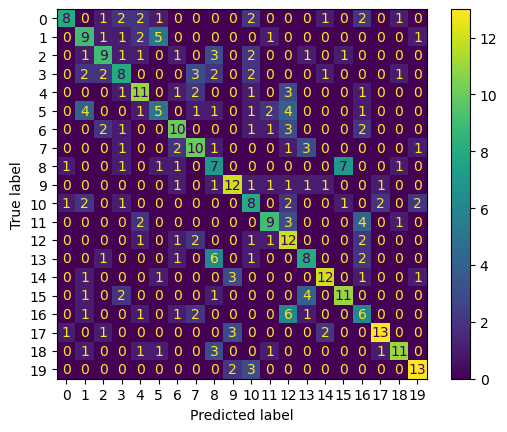

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(gt, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Test on personal data

In [35]:
import cv2
import torchvision.transforms as transforms
import pandas as pd
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

file = "class3.mp4"
cap = cv2.VideoCapture(file)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("num frames:",length)

video_container = np.zeros((240, 320, 3, 80), dtype = np.uint8)


ret = 1
frNum = 0
for indx, frameIndx in enumerate(range(80)):    
    ret, frame = cap.read()
    if ret:
        frame = cv2.resize(frame,(320, 240))
        video_container[..., indx] = frame
    else:
        print("Could not load frame")
        
cap.release()
print(video_container.shape)



lms_x = ["lmx"+str(i) for i in range(21)]
lms_y = ["lmy"+str(i) for i in range(21)]
lms_z = ["lmz"+str(i) for i in range(21)]
col_names = lms_x + lms_y + lms_z
df = pd.DataFrame(columns=col_names)

data = video_container
data = np.transpose(data,(3,0,1,2))

with mp_hands.Hands(
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:

    for frame_i,image in enumerate(data):
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            # print(results.multi_hand_landmarks[0].landmark[0])
            # exit()
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())
                lm_list_x = []
                lm_list_y = []
                lm_list_z = []
                for lm in hand_landmarks.landmark:
                    lm_list_x.append(lm.x)
                    lm_list_y.append(lm.y)
                    lm_list_z.append(lm.z)
            df.loc[len(df.index)] = lm_list_x+lm_list_y+lm_list_z
        else:
            df.loc[len(df.index)] = [0 for j in range(63)]


landmarks_seq = df.values
for col in range(landmarks_seq.shape[1]):
    x = landmarks_seq[:,col]
    x = medfilt(x,5)
    x = (x-np.min(x))/(np.max(x)-(np.min(x))+1e-6)
    x = (x-np.mean(x))/(np.std(x)+1e-6)
    landmarks_seq[:,col] = x


landmarks_seq = transforms.ToTensor()(landmarks_seq).float()

with torch.no_grad():
    model.eval()
    pred = model(landmarks_seq.to('cuda'))

print("prediction:",torch.argmax(pred).item())
print("ground truth:",file.split(".")[0])

num frames: 85
(240, 320, 3, 80)
prediction: 3
ground truth: class3


In [36]:
model = model.to('cpu')
torch.save(model.state_dict(), "test_acc_50.pth")